# Exploratory Analysis of Bike Data
In this project I will explore bike data from Ford GoBikes. I will focus on operational questions such as, how long are customers riding bikes, which stations are frequented the most, and if we can re-allocate bikes during the day where should we move bikes to? I'll try to learn as much as possible about how people use bikes using mainly plots

## Setup

In [1]:
# prerequisite package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import folium
from folium import plugins
from folium.plugins import HeatMap

%matplotlib inline

In [2]:
# Load dataset
bikes = pd.read_csv('2017-fordgobike-tripdata.csv')
bikes.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female


In [3]:
bikes.info()
bikes.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 15 columns):
duration_sec               519700 non-null int64
start_time                 519700 non-null object
end_time                   519700 non-null object
start_station_id           519700 non-null int64
start_station_name         519700 non-null object
start_station_latitude     519700 non-null float64
start_station_longitude    519700 non-null float64
end_station_id             519700 non-null int64
end_station_name           519700 non-null object
end_station_latitude       519700 non-null float64
end_station_longitude      519700 non-null float64
bike_id                    519700 non-null int64
user_type                  519700 non-null object
member_birth_year          453159 non-null float64
member_gender              453238 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 59.5+ MB


(519700, 15)

In [4]:
#bikes.describe()

## Cleaning
##### Making a copy
First I want to make a copy of the data set so we can reference in case we make any changes we want to undo.

In [5]:
bikes_clean = bikes.copy()

##### Add 'duration_min' column
Then I'll add a new column for duration in minutes for easy to read interpretation of trip duration.

In [6]:
bikes_clean['duration_min'] = bikes_clean['duration_sec']/60
bikes_clean.duration_min.describe()

count    519700.000000
mean         18.316825
std          57.402441
min           1.016667
25%           6.366667
50%           9.933333
75%          15.633333
max        1439.483333
Name: duration_min, dtype: float64

#### Convert String Dates into Datetime Objects
In order to plot usage over time, we'll need to access this column as a datetime object for ease on setting bins.

In [7]:
bikes_clean['start_time'] = pd.to_datetime(bikes_clean['start_time'])
type(bikes_clean['start_time'][0])

pandas._libs.tslibs.timestamps.Timestamp

##### Rearrange columns for visibility
Finally, I'll rearrange the columns a bit so the information I'm more interested in is closer to the left. We'll move the gps info all the way to the right and try to make use of that at a later time.

In [8]:
bikes_clean.columns
bikes_clean = bikes_clean[['duration_sec', 'duration_min', 'start_time', 'end_time', 'start_station_id',
       'start_station_name',  'end_station_id', 'end_station_name', 'bike_id', 'user_type', 'member_birth_year', 
        'member_gender', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']]
bikes_clean.head()

,duration_sec,duration_min,start_time,end_time,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,user_type,member_birth_year,member_gender,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,80110,1335.166667,2017-12-31 16:57:39.654,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,43,San Francisco Public Library (Grove St at Hyde...,96,Customer,1987.0,Male,37.776435,-122.426244,37.778768,-122.415929
1,78800,1313.333333,2017-12-31 15:56:34.842,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,96,Dolores St at 15th St,88,Customer,1965.0,Female,37.784872,-122.400876,37.766210,-122.426614
2,45768,762.800000,2017-12-31 22:45:48.411,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,245,Downtown Berkeley BART,1094,Customer,NaN,NaN,37.870348,-122.267764,37.870348,-122.267764
3,62172,1036.200000,2017-12-31 17:31:10.636,2018-01-01 10:47:23.5310,60,8th St at Ringold St,5,Powell St BART Station (Market St at 5th St),2831,Customer,NaN,NaN,37.774520,-122.409449,37.783899,-122.408445
4,43603,726.716667,2017-12-31 14:23:14.001,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,247,Fulton St at Bancroft Way,3167,Subscriber,1997.0,Female,37.868813,-122.258764,37.867789,-122.265896


In [9]:
#bikes_clean.start_station_name.value_counts()

# Univariate Exploration
- Bike Rental Duration
- gender as a proportion
- user type as a proportion
- distribution of age
- usage by hour
- usage by day of the week
- usage by month

### Bike Rental Duration

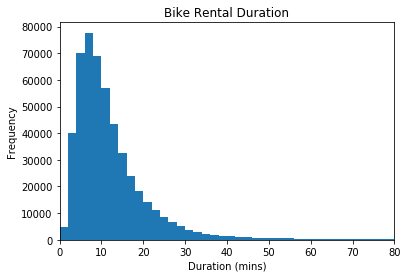

In [10]:
bin_edges = np.arange(0, bikes_clean['duration_min'].max()+50, 2)
plt.hist(data = bikes_clean, x = 'duration_min', bins=bin_edges)
plt.xlim(0, 80)
plt.title('Bike Rental Duration')
plt.xlabel('Duration (mins)')
plt.ylabel('Frequency');

### Gender as a Proportion

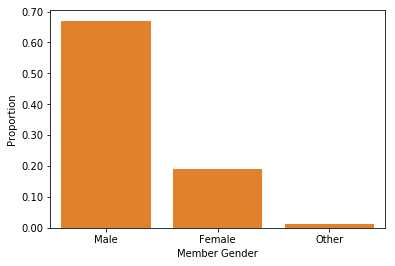

In [11]:
n_points = bikes_clean.shape[0]
max_count = bikes_clean['member_gender'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop+0.1, 0.10)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
base_color = sb.color_palette()[1]
plt.yticks(tick_props * n_points, tick_names)
sb.countplot(data = bikes_clean, x = 'member_gender', color = base_color)
plt.ylabel('Proportion')
plt.xlabel('Member Gender');

### Rider Age Distribution

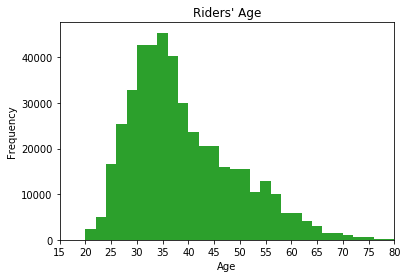

In [12]:
base_color = sb.color_palette()[2]
bikes_clean['age'] = 2019 - bikes['member_birth_year']
bin_edges = np.arange(0, bikes_clean['age'].max()+1, 2)
plt.hist(data = bikes_clean, x = 'age', bins=bin_edges, color = base_color)
plt.xticks([15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
plt.xlim(0, 80)
plt.title("Riders' Age")
plt.xlabel('Age')
plt.xlim(15, 80) # Riders need to be at least 18 to use program
plt.ylabel('Frequency');

### Rider Payment Type

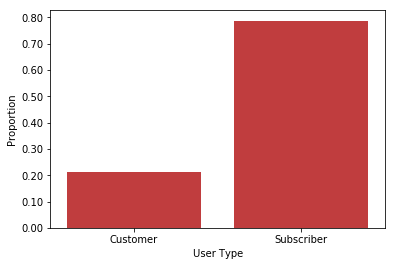

In [13]:
n_points = bikes_clean.shape[0]
max_count = bikes_clean['user_type'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop+0.1, 0.10)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
base_color = sb.color_palette()[3]
plt.yticks(tick_props * n_points, tick_names)
sb.countplot(data = bikes_clean, x = 'user_type', color = base_color)
plt.ylabel('Proportion')
plt.xlabel('User Type');

### Usage Throughout the Day

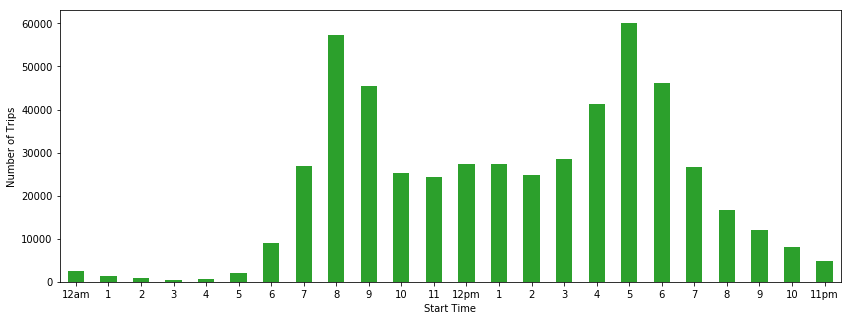

In [14]:
plt.figure(figsize = (14,5))
base_color = sb.color_palette()[2]
# hours = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
#         '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']
hours = ['12am', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
        '12pm', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11pm']
bikes_clean.groupby(bikes_clean.start_time.dt.hour).bike_id.count().plot(kind='bar', color = base_color);
# get the plot axes information
ax = plt.gca()
# get xtick positions
pos = ax.get_xticks().tolist()
# get xtick labels
labs = ax.get_xticklabels()
# change the xticks
plt.xticks(pos,hours, rotation = 'horizontal')
plt.xlabel('Start Time')
plt.ylabel('Number of Trips');

### Usage By Day of the Week

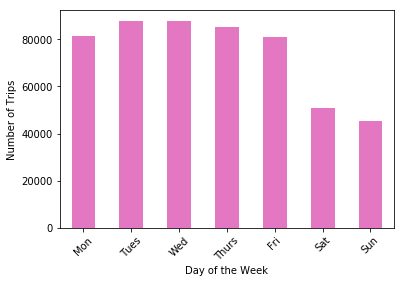

In [15]:
base_color = sb.color_palette()[6]
weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
bikes_clean.groupby(bikes_clean.start_time.dt.weekday).bike_id.count().plot(kind='bar', color = base_color)
# get the plot axes information
ax = plt.gca()
# get xtick positions
pos = ax.get_xticks().tolist()
# get xtick labels
labs = ax.get_xticklabels()
# change the xticks
plt.xticks(pos,weekdays, rotation = '45')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips');

### Usage By Month

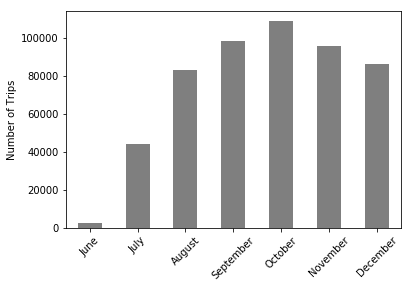

In [16]:
base_color = sb.color_palette()[7] 
months = ['June', 'July', 'August', 'September', 'October', 'November', 'December']
bikes_clean.groupby(bikes_clean.start_time.dt.month).bike_id.count().plot(kind='bar', color = base_color)
# get the plot axes information
ax = plt.gca()
# get xtick positions
pos = ax.get_xticks().tolist()
# get xtick labels
labs = ax.get_xticklabels()
# change the xticks
plt.xticks(pos,months, rotation = '45')
plt.xlabel('')
plt.ylabel('Number of Trips');

# Bivariate Exploration

### Exploring Age and Trip Duration

Start with Scatterplot

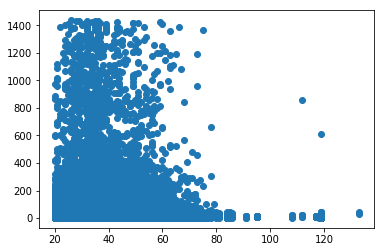

In [17]:
plt.scatter(data = bikes_clean, x = 'age', y = 'duration_min', );

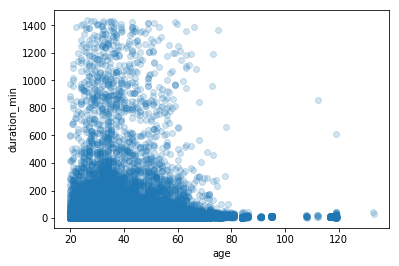

In [18]:
sb.regplot(data = bikes_clean, x = 'age', y = 'duration_min', fit_reg = False, 
           x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/5});

Even with jitter and adjusting alpha values, its hard to take much from the scatter plot other than there's a lot of values in the in the bottom left of the plot. A heat map could give us a better idea of the density of the spread in this area.

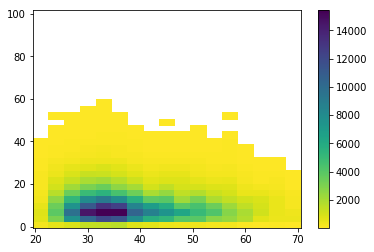

In [19]:
bins_x = np.arange(19.6, 70.5+3, 3)
bins_y = np.arange(-0.5, 100.5+3, 3)
plt.hist2d(data = bikes_clean, x = 'age', y = 'duration_min',
           bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 35)
plt.colorbar()

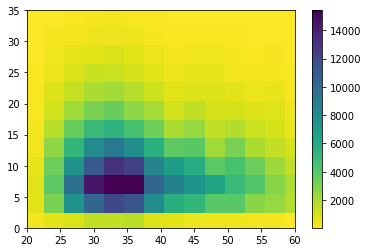

In [20]:
plt.hist2d(data = bikes_clean, x = 'age', y = 'duration_min',
           bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 35)
plt.colorbar()
plt.xlim(20, 60)
plt.ylim(0, 35);

Text(0, 0.5, 'Mean Duration (Mins)')

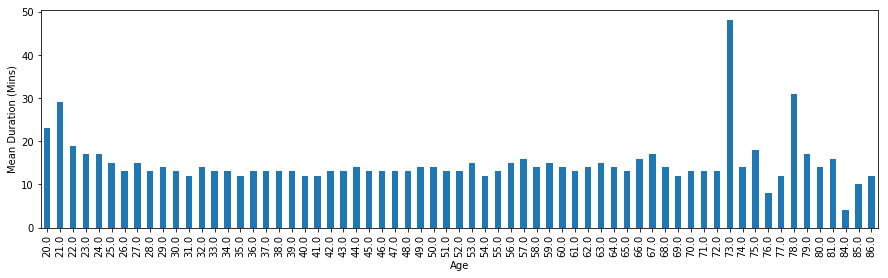

In [21]:
# age_grouped = bikes_clean[['age', 'duration_min']]
#age_grouped = bikes_clean.groupby(bikes_clean.age).duration_min.mean()
plt.figure(figsize = (15,4))
base_color = sb.color_palette()[0]
# trimming our data set for more realistic age values. Had some unlikely values above 90
bikes_trimmed = bikes_clean.query('age <= 90')
bikes_trimmed.groupby(bikes_trimmed.age).duration_min.mean().astype(int).plot(kind='bar', color = base_color)
plt.xlabel('Age')
plt.ylabel('Mean Duration (Mins)')

### Violin Plot of Payment Type and Duration of Trip

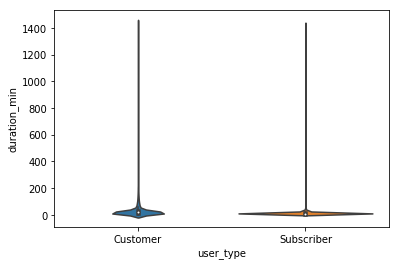

In [22]:
sb.violinplot(data = bikes_clean, x = 'user_type', y = 'duration_min');

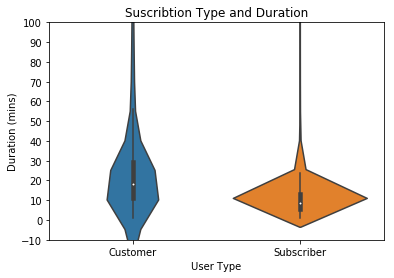

In [23]:
sb.violinplot(data = bikes_clean, x = 'user_type', y = 'duration_min');
plt.ylim(-10, 100)
plt.title("Suscribtion Type and Duration")
plt.xlabel('User Type')
plt.yticks([-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.ylabel('Duration (mins)');

In [24]:
bikes_clean.query("user_type == 'Customer'").duration_min.describe()

count    110470.000000
mean         42.624096
std         105.921861
min           1.016667
25%          11.116667
50%          18.100000
75%          29.233333
max        1439.483333
Name: duration_min, dtype: float64

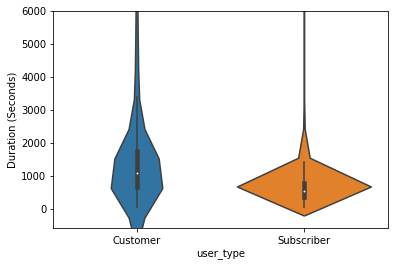

In [25]:
sb.violinplot(data = bikes_clean, x = 'user_type', y = 'duration_sec')
plt.ylim(-600, 6000)
plt.ylabel('Duration (Seconds)');

### Time series plot of avg trip duration over the course of a day (aka line plot)

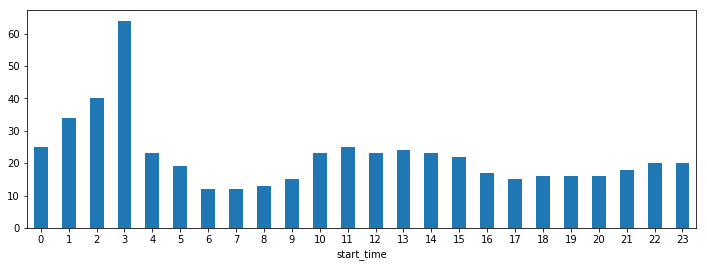

In [26]:
plt.figure(figsize = (12, 4))
bikes_clean.groupby(bikes_clean.start_time.dt.hour).duration_min.mean().astype(int).plot(kind='bar', color = base_color)
plt.xticks(rotation = 'horizontal');

### Time series plot of avg trip duration on different months, looking at seasons(aka line plot)


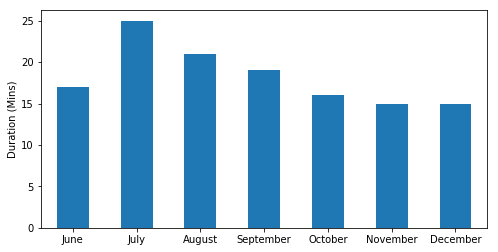

In [27]:
plt.figure(figsize = (8, 4))
months = ['June', 'July', 'August', 'September', 'October', 'November', 'December']
bikes_clean.groupby(bikes_clean.start_time.dt.month).duration_min.mean().astype(int).plot(kind='bar', color = base_color)
# get the plot axes information
ax = plt.gca()
# get xtick positions
pos = ax.get_xticks().tolist()
plt.xticks(pos, months, rotation = 'horizontal')
plt.xlabel('')
plt.ylabel('Duration (Mins)');

# Multivariate Exploration

### Heat Map of Usage in different Zones using GPS coordinates

In [36]:
bikes_clean.columns
#bikes_clean.shape

Index(['duration_sec', 'duration_min', 'start_time', 'end_time',
       'start_station_id', 'start_station_name', 'end_station_id',
       'end_station_name', 'bike_id', 'user_type', 'member_birth_year',
       'member_gender', 'start_station_latitude', 'start_station_longitude',
       'end_station_latitude', 'end_station_longitude', 'age'],
      dtype='object')

In [35]:
# filter for gps locations within San Francisco
sf_bikes = bikes_clean.query("start_station_latitude >= 37.707000 and start_station_latitude < 37.8100000 and start_station_longitude > -122.51000 and start_station_longitude <= -122.3700000")
sf_bikes = sf_bikes.query("end_station_latitude >= 37.707000 and end_station_latitude < 37.8100000 and end_station_longitude > -122.51000 and end_station_longitude <= -122.3700000")
sf_bikes.shape

# AM commute 7am to 10am
AM = sf_bikes.query("start_time.dt.hour >= 7 and start_time.dt.hour <= 10")

# PM commute 3pm to 6pm
PM = sf_bikes.query("start_time.dt.hour >= 15 and start_time.dt.hour <= 18")

(411324, 17)

### AM Commute Heat Map

In [46]:
bikes_short = AM.sample(5000, replace=True)

# grab image of SF map
sf = folium.Map(location=[37.775204, -122.418747],
                    zoom_start = 13) 
# build df to plug into heatmap func from sampled data to make processing faster
heat_df = bikes_short[['start_station_latitude', 'start_station_longitude']]
heat_df = bikes_short.dropna(axis=0, subset=['start_station_latitude', 'start_station_longitude'])

# List comprehension to make out list of lists
heat_data = [[row['start_station_latitude'],row['start_station_longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(sf)

# Display the map
sf

## PM Commute Map
Bike rides start between 3pm to 6pm

In [48]:
bikes_short = PM.sample(5000, replace=True)

# grab image of SF map
sf = folium.Map(location=[37.775204, -122.418747],
                    zoom_start = 13) 
# build df to plug into heatmap func from sampled data to make processing faster
heat_df = bikes_short[['start_station_latitude', 'start_station_longitude']]
heat_df = bikes_short.dropna(axis=0, subset=['start_station_latitude', 'start_station_longitude'])

# List comprehension to make out list of lists
heat_data = [[row['start_station_latitude'],row['start_station_longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(sf)

# Display the map
sf

The entirety of Castro, Mission, Market, Financial District, Downtown, Soma, etc. are red. Lets see where the rides end

In [50]:
PM_end = PM.sample(5000, replace=True)

# grab image of SF map
sf = folium.Map(location=[37.775204, -122.418747],
                    zoom_start = 13) 
# build df to plug into heatmap func from sampled data to make processing faster
heat_df = PM_end[['end_station_latitude', 'end_station_longitude']]
heat_df = PM_end.dropna(axis=0, subset=['end_station_latitude', 'end_station_longitude'])

# List comprehension to make out list of lists
heat_data = [[row['end_station_latitude'],row['end_station_longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(sf)

# Display the map
sf

### Calcuations of Different Areas to Gauge Where More Bikes Are Needed

# Testing Code

# OLD CODE DO NOT USE

In [34]:
# old date time code
# base_color = sb.color_palette()[4] 
# bikes_clean['time_hour'] = bikes_clean.start_time.apply(lambda x: x.hour)
# bikes_clean['time_hour']
# sb.countplot(data = bikes_clean, x = 'time_hour', color = base_color)

# attempt at using frequency poly plot
# def freq_poly(x, bins = 10, **kwargs):
#     """ Custom frequency polygon / line plot code. """
#     # set bin edges if none or int specified
# #     if type(bins) == int:
# #         bins = np.linspace(x.min(), x.max(), bins+1)
#     bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

#     # compute counts
#     data_bins = pd.cut(x, bins, right = False,
#                        include_lowest = True)
#     counts = x.groupby(data_bins).count()

#     # create plot
#     plt.errorbar(x = bin_centers, y = counts, **kwargs)

# bin_edges = np.arange(0, bikes_clean['duration_min'].max()+5, 5)
# g = sb.FacetGrid(data = bikes_clean, hue = 'member_gender', size = 5)
# g.map(freq_poly, bikes_clean['duration_min'], bins = bin_edges)
# g.add_legend()

# frequency poly that kind of works but too blocky
# bin_edges = np.arange(0, bikes_clean['duration_min'].max()+5, 5)
# g = sb.FacetGrid(data = bikes_clean, hue = 'member_gender', size = 5)
# g.map(plt.hist, "duration_min", bins = bin_edges, histtype = 'step')
# plt.xlim(0, 70)
# g.add_legend()

# mark each station as a point
# for index, row in bikes_short.iterrows():
#     folium.CircleMarker(location= [row['start_station_latitude'], row['start_station_longitude']],
#                         radius=10,
#                         popup=row['start_station_name'],
#                         fill_color="#3db7e4").add_to(m)
# # convert to (n, 2) nd-array format for heatmap
# stationArr = bikes_short[['start_station_latitude', 'start_station_longitude']].to_numpy()

# # plot heatmap
# m.add_child(plugins.HeatMap(stationArr, radius=10))